In [1]:
%load_ext autoreload
%autoreload 2

#Packages
import numpy as np
import matplotlib.pyplot as plt 
import time

#.py
from core import qlearning as q 
from core import prices as pr 

## Variation of demand function or price grid 

In [2]:
start = time.time()
aggregated_agents = []
for demand, price in [[False, [None,None]], [True, [None,None]], [False,[1,2]]]:
    total_rewards = []

    for loop in range(3):
        print("Loop:", loop, "binary demand : ", demand, "prices variation:", price)
        agents = [q.Agent(binary_demand=demand, pN=price[0],pC=price[1]) for _ in range(2)]
        env = q.Env(binary_demand=demand)

        temps = []
        rewards = []
        epsilon = []
        prices = []

        # Initialisation des prix p0 (on va le faire directement dans chaque agent)
        for agent in agents:
            agent.p = np.random.choice(agent.A)

        # Initialisation de l'état
        s_t = env([agent.p for agent in agents])[1]
        for agent in agents:
            agent.s_t = s_t

        s_ind = agents[0].find_index(agents[0].s_t)
        for agent in agents:
            agent.s_ind = s_ind

        # Phase itérative
        for t in range(1000):
            # Actions et état t+1
            for agent in agents:
                agent.a_ind = agent.get_next_action()

            s_t1 = env([agent.A[agent.a_ind] for agent in agents])[1]
            for agent in agents:
                agent.s_t1 = s_t1

            s_ind1 = agents[0].find_index(agents[0].s_t1)
            for agent in agents:
                agent.s_ind1 = s_ind1

            temps.append(t)
            ret = env(s_t1)
            quant, price, cost = ret

            re = ret[0]*ret[1]-ret[0]*ret[2]
            rewards.append(re)
            epsilon_values = [agent.epsilon for agent in agents]
            epsilon.append(epsilon_values)
            prices.append([agent.p for agent in agents])

            for i, agent in enumerate(agents):
                agent.updateQ(q=quant[i], p=price[i], c=cost[i], t=t)

        total_rewards.append(rewards)

    aggregated_agents.append(np.array(total_rewards).mean(axis=0))
end = time.time()

print(aggregated_agents)
print(end-start)

Loop: 0 binary demand :  False prices variation: [None, None]
Loop: 1 binary demand :  False prices variation: [1.77547642351742, 1.8924673942262193]
Loop: 2 binary demand :  False prices variation: [1.8339719088718196, 1.7738051239358659]
Loop: 0 binary demand :  True prices variation: [None, None]
Loop: 1 binary demand :  True prices variation: [1.3357142857142856, 1.1642857142857144]
Loop: 2 binary demand :  True prices variation: [1.2646938775510204, 1.25]
Loop: 0 binary demand :  False prices variation: [1, 2]
Loop: 1 binary demand :  False prices variation: [1.4142857142857144, 1.5857142857142859]
Loop: 2 binary demand :  False prices variation: [1.5734693877551023, 1.5587755102040817]
[array([[0.27619275, 0.33335215],
       [0.29327175, 0.34374947],
       [0.26019837, 0.33080687],
       ...,
       [0.31177033, 0.30792493],
       [0.26336134, 0.32848793],
       [0.33903031, 0.31832801]]), array([[0.08290816, 0.13187377],
       [0.12429202, 0.01147959],
       [0.06267456, 

In [3]:
aggregated_agents

[array([[0.27619275, 0.33335215],
        [0.29327175, 0.34374947],
        [0.26019837, 0.33080687],
        ...,
        [0.31177033, 0.30792493],
        [0.26336134, 0.32848793],
        [0.33903031, 0.31832801]]),
 array([[0.08290816, 0.13187377],
        [0.12429202, 0.01147959],
        [0.06267456, 0.06934786],
        ...,
        [0.06309051, 0.0533102 ],
        [0.14826572, 0.02288265],
        [0.03112719, 0.1393925 ]]),
 array([[0.18677666, 0.18186743],
        [0.16003533, 0.14518681],
        [0.29837737, 0.22368342],
        ...,
        [0.31179983, 0.1912283 ],
        [0.24309474, 0.17196717],
        [0.25804381, 0.23653032]])]

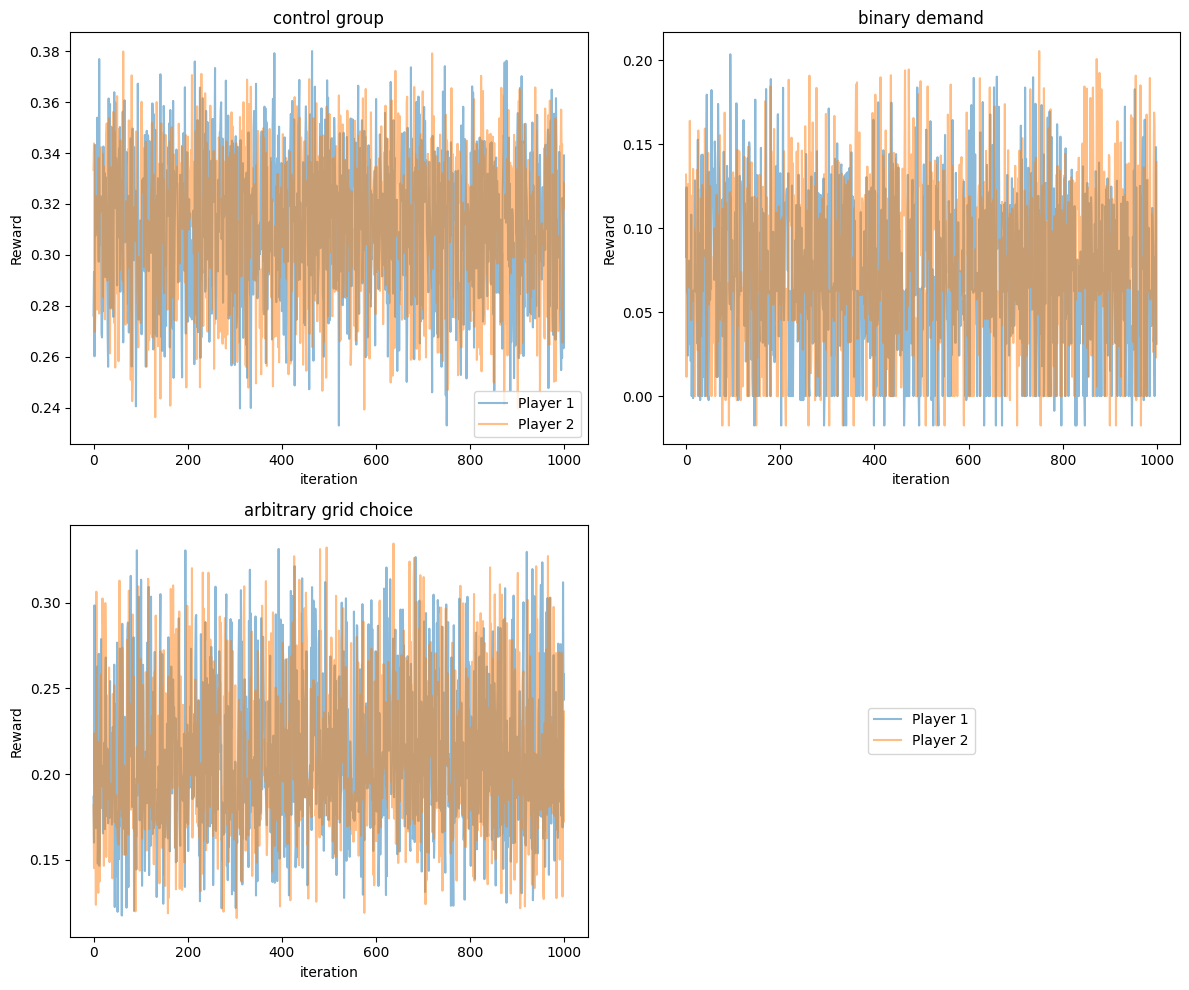

In [4]:
num_players = 2
num_graphs = len(aggregated_agents)
legend = ["control group", "binary demand", "arbitrary grid choice"]

# Create a figure with a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the axes array to iterate over the subplots
axes = axes.flatten()

# Loop to iterate through the periods and subplots
for graph_num in range(num_graphs):
    ax = axes[graph_num]
    num_players = len(aggregated_agents[graph_num][0])
    # Plot curves for each player in the subplot
    for player in range(num_players):
        ax.plot(aggregated_agents[graph_num][:, player], alpha=0.5, label=f'Player {player + 1}')
    
    # Set the title of the subplot with the corresponding period
    ax.set_title(legend[graph_num])
    
    # Set the labels of the subplot
    ax.set_xlabel('iteration')
    ax.set_ylabel('Reward')

    # Add a legend to the first subplot
    if graph_num == 0:
        ax.legend()

# Remove any unused subplots
if num_graphs < 3:
    for i in range(num_graphs, 3):
        fig.delaxes(axes[i])

# Create a legend in the last subplot
legend_ax = axes[-1]
legend_ax.axis('off')

# Get the legend handles and labels from the first subplot
handles, labels = axes[0].get_legend_handles_labels()

# Create the legend in the last subplot
legend_ax.legend(handles, labels, loc='center')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In [5]:
prices = pr.PriceOptimizer()
collusion_profit, collusion_prices = prices.CollusionPrice()
nash_profit, nash_prices = prices.NashPrice()
RN = nash_profit
RC = collusion_profit
    
Rmean = np.zeros((len(aggregated_agents), 2))
DRmean = np.zeros((len(aggregated_agents), 2))   
    
for i in range (len(aggregated_agents)): 
    for j in range (2):
        Rmean[i][j] = aggregated_agents[i][-100:,j].mean()
        DRmean[i][j] = (Rmean[i][j] - RN)/(RC - RN) 

print(DRmean)

[[ 0.78395703  0.7452285 ]
 [-1.36322025 -1.19499598]
 [-0.05651999 -0.11201253]]


[ 0.76459277 -1.27910811 -0.08426626]


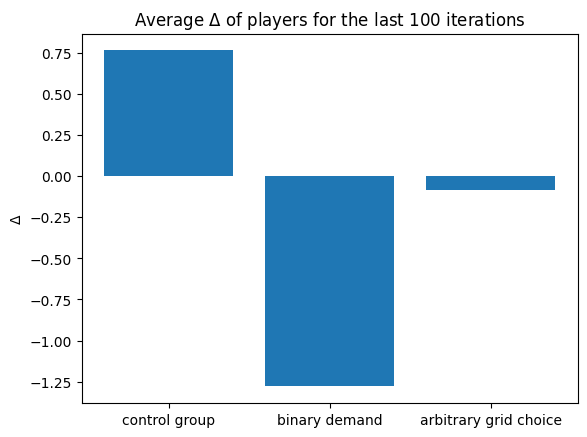

In [6]:
av = np.mean(DRmean, axis=1)
print(av)
plt.bar(["control group", "binary demand", "arbitrary grid choice"],av)
plt.ylabel('$\\Delta$')
plt.title('Average $\\Delta$ of players for the last 100 iterations')
plt.show()